<a href="https://colab.research.google.com/github/jayaramanp/Computational_Psych_class/blob/dev/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to **Lab 1**! 

Please start by making your own copy of this Google Colab notebook (you will need a Google account). 

In this lab, we will simulate behavior from an agent that is learning to select the best action in a multiarmed bandit environment. We will assume that: the agent is behaving according to an epsilon-greedy policy (that is, most of the time it *exploits* the action currently thought to be the best, and sometimes it *explores* a random action); and it is learning using a delta rule (that is, it uses the current reward to update the estimated value of the chosen action).

Learning objectives:  

* Implement and visualize a learning environment 
* Implement an RL agent that learns and selects actions using a given algorithm 
* Simulate and quantify behavior of the agent
* Understand how different parameters change the behavior and performance of the agent
* Modify the agent to implement a different policy

The cell below imports some necessary modules:



In [ ]:
import numpy as np  
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

To define different components of our simulation, we will make use of [object oriented programming (OOP)](https://realpython.com/python3-object-oriented-programming/). OOP is helpful because it lets us define general classes we can reuse across different simulations to create new instances of each component (e.g. different instances of an agent, environment, etc).  

# We start by defining the environment class:


In [ ]:
class Environment(object):
  
  """Class for the multiarmed bandit environment.

  Parameters
  ----------
  k : int
      Number of arms.
  mu : array, float, shape(k, )
      Mean for each arm.
  sigma : array, float, shape(k, )
      Standard deviation for each arm. 

  """

  def __init__(self, k, mu, sigma):

    """Constructor for the Environment class
    This function runs every time we create an instance of the class Environment
    To learn more about how constructors work: https://www.udacity.com/blog/2021/11/__init__-in-python-an-overview.html"""

    # "self" is just a convention that binds the attributes and methods of a class with the arguments of a given instance

    self.k = k          # number of arms
    self.mu = mu        # mean of reward distribution for each arm
    self.sigma = sigma  # standard deviation of reward distribution for each arm
    self.t = 0          # initialize timestep
    
    if self.mu.shape[0] is not k:
      raise Warning("Mean vector shape does not match number of arms")

    if self.sigma.shape[0] is not k:
      raise Warning("Sigma vector shape does not match number of arms")

  def visualize(self, style):

    # this method lets us visualize the structure of the environment
    # in the multiarmed bandit case, this consists of the reward distribution for each arm 

    # visualize as Gaussian densities
    if style == 1:
      
      x = np.arange(-5, 5, 0.001)

      for i in np.arange(self.k):
        plt.plot(x, norm.pdf(x, self.mu[i], self.sigma[i]), label='μ: ' + str(self.mu[i]) + ', σ: ' + str(self.sigma[i]))

      plt.legend()
      plt.xlabel('Reward distribution')
      plt.ylabel('Density')

    # draw many samples from each distribution and plot histograms
    if style == 2: 

      # initialize output list 
      bandit = []   # which bandit we're drawing from
      samples = []  # samples we drew

      # iterate over each bandit
      for i in np.arange(self.k):
        
        n_samples = 1000

        # create bandit index
        b = list(np.ones((n_samples, )) * (i+1))

        # draw samples
        s = list(np.random.normal(self.mu[i], self.sigma[i], n_samples))
  
        # add to lists  
        bandit = bandit + b
        samples = samples + s

      # create pandas dataframe from dictionary
      # background on dictionaries: https://www.w3schools.com/python/python_dictionaries.asp
      # background on dataframes: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html 
      df = pd.DataFrame({'bandit': list(map(int, bandit)), 
                         'samples': samples})
      
      # use seaborn to plot distributions
      # background on seaborn: https://seaborn.pydata.org/index.html
      sns.violinplot(data=df, x="bandit", y="samples")
      
      plt.xlabel('Action')
      plt.ylabel('Reward distribution')

  def step(self, action):

    # the step method takes as input an action and changes the environment
    # in the bandit case, the environment responds with a reward

     # draw reward
    reward = np.random.normal(self.mu[action-1], self.sigma[action-1], 1)[0]

    # increment timestep
    self.t = self.t + 1

    # comment the next line in if you want to print the time step
    # print('timestep: ' + str(self.t))

    return reward

# Let's test our environment...

In [ ]:
# Initialize a 10-armed bandit where each arm has an increasing mean and standard deviation of 1
n_arms = 10
means = np.arange(n_arms)-5
sds = np.ones((n_arms,))

# This line creates an instance of the class we defined above with some attributes
env = Environment(n_arms, means, sds)

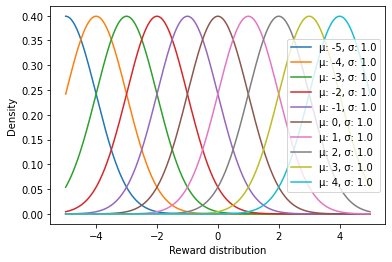

In [ ]:
# Visualize
# Note how now we can access the method inside the class for this specific instance
env.visualize(1)

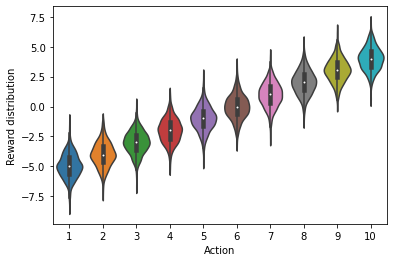

In [ ]:
env.visualize(2)

In [ ]:
# Draw rewards for each action
for a in np.arange(10):
  action = a + 1
  print('took action ' + str(action))
  print('reward: ' + str(env.step(action)))

took action 1
reward: -4.8726661825441075
took action 2
reward: -2.6511755814478217
took action 3
reward: -2.281639835854462
took action 4
reward: -1.4112153692967428
took action 5
reward: -0.5994069270297129
took action 6
reward: 0.2361614810028732
took action 7
reward: 1.7090000713939735
took action 8
reward: -0.15385519191499553
took action 9
reward: 4.2579122390694355
took action 10
reward: 3.143519951368428


# Next, we define the agent:

In RL, it is useful to separate the environment from the agent. In the next class, we will see how we can expand our definition of the environment, and model how an agent interacts with it via the actions it takes.

In [ ]:
class Agent(object):
  """Class for the e-greedy agent.

  Parameters
  ----------
  epsilon : float, range (0, 1)
      Epsilon probability of exploration.

  """

  def __init__(self, env, epsilon, q_init=False):

    # initialize action space
    self.action_space = np.arange(env.k) + 1

    # initialize parameters
    self.eps = epsilon
    
    # initialize Q-values and action counters
    if q_init: # check if initial q-values were provided 
      self.q = q_init     
    else:   
      self.q = np.zeros((env.k, ))
    
    # initialize action counter
    self.action_counter = np.zeros((env.k, ))  

  def policy(self):

    # for now, you can think of the policy method as encoding how 
    # an agent selects actions.
    # in the epsilon-greedy case, the agent has an internal representation
    # of the value of each action. its policy is to pick the action with the 
    # highest value with probability 1-epsilon and explore a random action with 
    # probabilty epsilon.  

    # generate random number between 0 and 1.
    # this draws from a uniform distribution, so we have an equal probability
    # of generating any real number between 0 and 1.
    p = np.random.rand()

    # select action
    if (p < self.eps): # is the number we drew is smaller than epsilon? 
      action = np.random.choice(env.k)+1 # random action
    else: 
      action = np.argmax(self.q)+1 # action with highest q-value     
    
    return action

  def update(self, action, reward, verbose=False):

    # the update method encodes how the agent learns from its actions. 
    # it takes as input the action and reward.
  
    # update action counter
    self.action_counter[action-1] = self.action_counter[action-1] + 1

    # update value of selected action in proportion to the difference between the 
    # current reward and the previous value, times a step size 
    # equal to the inverse of how many times the agent selected that action in the past.
    # in other words, the step size will be smaller the more we select that action. 
    self.q[action-1] = self.q[action-1] + 1/self.action_counter[action-1] * (reward - self.q[action-1])

    if verbose == True: 
      print(self.q)

# We can now reproduce the simulation results:

We saw in lecture today our first example of a simulation. Simulating behavior from a computational model is often the first step of using that model to ask a new scientific question. From [Wilson and Collins (2019)](https://elifesciences.org/articles/49547): "simulation involves running the model with particular parameter settings to generate ‘fake’ behavioral data. These simulated data can then be analyzed in much the same way as one would analyze real data, to make precise, falsifiable predictions about qualitative and quantitative patterns in the data. Simulation is a way to make theoretical predictions more precise and testable."

In [ ]:
def run_simulation(n_timesteps, params, verbose=False):

  """Function for running one simulation of the bandit problem.
  It specifies how the environment and agent interact over the course
  of multiple timesteps.

  Parameters
  ----------

  n_timesteps: int
      How many timesteps to run the simulation for

  params : dictionary containing parameters of the simulation 

      Environment parameters
      n_arms: int
        Number of arms.
      means: array, float, shape(n_arms, )
        Means for each arm.
      sds: array, float, shape(n_arms, )
        Standard deviations for each arm.
      
      Agent parameters
      epsilon: float, range (0, 1)
        Epsilon probability of exploration.

  verbose: flag for printing some output

  Returns
  ----------

  sim_output: dictionary containing simulation output

      actions: array, int, shape(n_timesteps, )
        Action that the agent took on each timestep.

      rewards: array, float, shape(n_timesteps, )
        Rewards that the agent received on each timestep.

      optimal_action: array, boolean, shape(n_timestep, )
        Indicator vector that tells us if the agent took the best possible action.
  """

  # make environment (10-arm testbed with varying means and same standard deviation)
  env = Environment(params['n_arms'], params['means'], params['sds'])

  # initialize agent 
  agent = Agent(env, params['epsilon'])

  # initialize output lists
  A = [] # action taken at each timestep
  R = [] # rewards on each timestep
  OA = [] # was the optimal action taken at each timestep? 

  # loop for given number of timesteps
  for t in np.arange(n_timesteps):

    # agent selects action
    action = agent.policy()

    # environment responds with a reward
    reward = env.step(action)

    # record action and reward
    A.append(action)
    R.append(reward)

    # record whether the agent took the optimal action
    optimal_action = np.argmax(params['means'])+1
    OA.append(action == optimal_action)
    
    if verbose: 
      print('action: ' + str(action))
      print('reward: ' + str(reward))

    agent.update(action, reward, verbose=False)

  # record output in dictionary
  sim_output = {
      'timestep': np.arange(n_timesteps)+1,
      'actions': np.array(A),
      'rewards': np.array(R),
      'optimal_action': np.array(OA)
  }

  return env, agent, sim_output

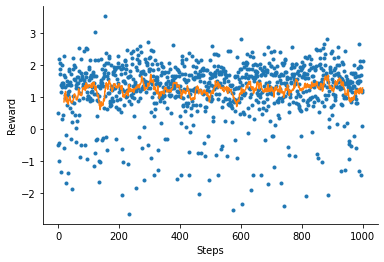

In [ ]:
# Run simulation once
n_timesteps = 1000
params = {
    'n_arms': 10,
    'means': np.array([0.5, -0.9, 1.5, 0.7, 1.3, -1.5, -0.3, -1, 0.9, -0.7]),
    'sds': np.ones((n_arms,)) * 0.5,
    'epsilon': 0.2 
}

sim_env, sim_agent, sim_output = run_simulation(n_timesteps, params)
df = pd.DataFrame(sim_output['rewards'])

# Plot reward at each timestep
plt.plot(np.arange(n_timesteps), sim_output['rewards'], '.')
plt.plot(np.arange(n_timesteps), df.rolling(20).mean(), '-')
plt.xlabel('Steps')
plt.ylabel('Reward')
sns.despine();

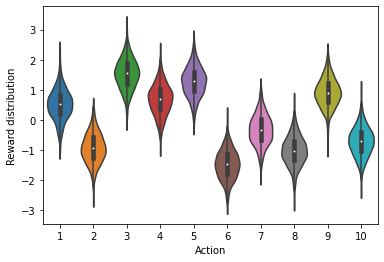

In [ ]:
# Check environment
sim_env.visualize(2)

The goal of the simulation in lecture was to examine how the performance of the epsilon-greedy agent changes as a function of parameter epsilon. Let's reproduce that experiment below. 

In [ ]:
# Run simulation many times for different values of epsilon
n_runs = 2000

# Initialize output list
D = []
  
for e in [0.1, 0.01, 0]:

  print('epsilon = '  + str(e))

  for r in np.arange(n_runs): 

    print('simulation #: ' + str(r+1))

    n_timesteps = 1000
    params = {
      'n_arms': 10,
      'means': np.array([0.5, -0.9, 1.5, 0.7, 1.3, -1.5, -0.3, -1, 0.9, -0.7]),
      'sds': np.ones((n_arms,)) * 0.5,
      'epsilon': e 
    }

    _, _, sim_output = run_simulation(n_timesteps, params)

    # convert to dataframe and append to list
    d = pd.DataFrame(sim_output)
    d.insert(0, 'run', r+1)
    d.insert(1, 'epsilon', e)
    D.append(d)

data = pd.concat(D, ignore_index=True)

Streaming output truncated to the last 5000 lines.
simulation #: 1003
simulation #: 1004
simulation #: 1005
simulation #: 1006
simulation #: 1007
simulation #: 1008
simulation #: 1009
simulation #: 1010
simulation #: 1011
simulation #: 1012
simulation #: 1013
simulation #: 1014
simulation #: 1015
simulation #: 1016
simulation #: 1017
simulation #: 1018
simulation #: 1019
simulation #: 1020
simulation #: 1021
simulation #: 1022
simulation #: 1023
simulation #: 1024
simulation #: 1025
simulation #: 1026
simulation #: 1027
simulation #: 1028
simulation #: 1029
simulation #: 1030
simulation #: 1031
simulation #: 1032
simulation #: 1033
simulation #: 1034
simulation #: 1035
simulation #: 1036
simulation #: 1037
simulation #: 1038
simulation #: 1039
simulation #: 1040
simulation #: 1041
simulation #: 1042
simulation #: 1043
simulation #: 1044
simulation #: 1045
simulation #: 1046
simulation #: 1047
simulation #: 1048
simulation #: 1049
simulation #: 1050
simulation #: 1051
simulation #: 1052

In [ ]:
# Examine output
data

,run,epsilon,timestep,actions,rewards,optimal_action
0,1,0.1,1,1,0.612002,False
1,1,0.1,2,1,0.502967,False
2,1,0.1,3,1,0.951730,False
3,1,0.1,4,1,0.013887,False
4,1,0.1,5,1,0.330116,False
...,...,...,...,...,...,...
5999995,2000,0.0,996,3,1.424632,True
5999996,2000,0.0,997,3,-0.098939,True
5999997,2000,0.0,998,3,1.054462,True
5999998,2000,0.0,999,3,2.073138,True


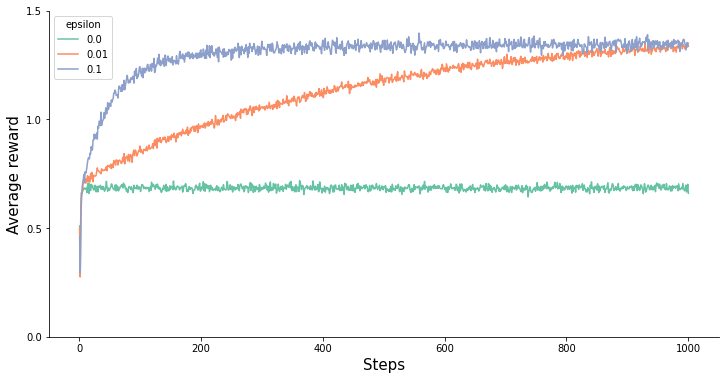

In [ ]:
# Plot average reward across different runs, for each value of epsilon
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.lineplot(data=data, x="timestep", y="rewards", hue='epsilon', ci=None, ax=ax, palette='Set2')
ax.set_ylim([0, 1.5])
ax.set_yticks([0, 0.5, 1, 1.5])
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Average reward', fontsize=15)
sns.despine();

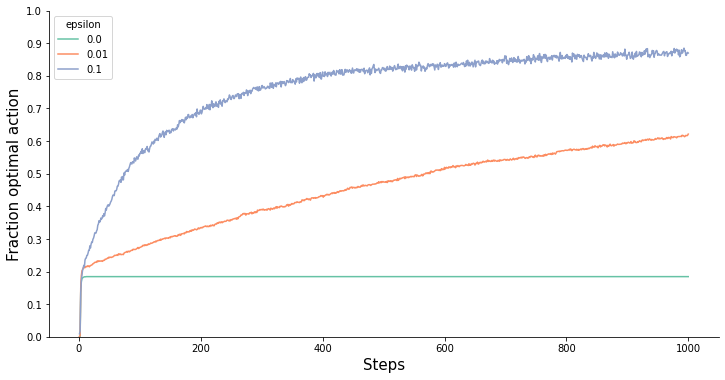

In [ ]:
# Plot fraction correct across different runs, for each value of epsilon 
fig, ax = plt.subplots(1, 1, figsize=(12,6))
sns.lineplot(data=data, x="timestep", y="optimal_action", hue='epsilon', ci=None, ax=ax, palette='Set2')
ax.set_ylim([0, 1])
ax.set_yticks(np.arange(11)/10)
ax.set_xlabel('Steps', fontsize=15)
ax.set_ylabel('Fraction optimal action', fontsize=15)
sns.despine();

And that's it! Congratulations on running your first experiment! Below are some exercises to help you practice asking additional questions by simulating behavior in the multiarmed bandit environment.

# Exercises

As you work on these, you may re-use or modify any of the code above. You are welcome to work in groups, though each student should turn in an individual notebook with answers by uploading to this [Google Drive folder](https://drive.google.com/drive/folders/1Tf99kycwrvAFJ_D7stayd8RkrWOXEds1).  

1. In the previous simulation, we found that as we increase epsilon, that is, as agents become more exploratory, performance always increases. Do you think this will be the case for ranges of epsilon in which the agent almost always explores? Why or why not? Modify the simulation script above to verify your intuition. If you found that the answer is no, at what value of epsilon do we start noticing diminishing returns of exploration?  

2. In lecture, we learned that another way to encourage exploration is by allowing agents to start with optimistic initial values. Check that this is the case by comparing the performance of a wildly optimistic agent that starts with $Q_t = 5$ and greedily selects actions, to that of a realistic agent which explores randomly with probability $ϵ = 0.1$ (hint, see plot from lecture). 

3. Modify the agent's policy to add uncertainty-driven exploration using the UCB algorithm from lecture. How does the agent's performance change as a function of the $c$ parameter? 

4. Modify the Environment class to implement the 4-armed bandit task described in [Addicott et al. (2017)](https://www.nature.com/articles/npp2017108). Confirm by visualizing the reward structure.

